In [12]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

下面的代码生成人造数据集

In [13]:
def synthetic_data(w, b, num_examples):
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)  # 添加噪音，其标准差设为0.01
    return X, y.reshape((-1, 1))


true_w = torch.tensor([2, -3.4])  # 随便取的初始化参数
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

print('features:', features, '\nlabel:', labels[0])

features: tensor([[-0.1136, -0.1275],
        [-0.1977, -1.3759],
        [ 1.2612, -0.9227],
        ...,
        [ 0.0763,  0.6314],
        [ 0.4591, -0.7614],
        [-0.1679, -0.0763]]) 
label: tensor([4.4222])


观察散点图

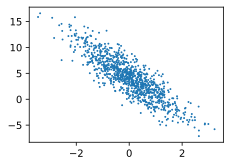

In [14]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1);

定义一个函数，能打乱数据集中的样本并以小批量方式获取数据。

In [25]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)

    for i in range(0, num_examples, batch_size):
        # 每次生成一小部分索引数组
        batch_indices = torch.tensor(indices[i:min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

# 函数中 for 语句里的 yield ,可以在每次函数被调用时，返回当前一趟的结果。换言之，yield 就是多次分批 return

# torch.tensor() 和 torch.Tensor() 的不同：
#   torch.Tensor()是 Python 类，更明确的说，是默认张量类型torch.FloatTensor()的别名，错误使用时会报类型错


打印一小批数据：

In [26]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

<class 'int'>
tensor([[ 1.6951, -0.6785],
        [-1.3737,  0.3512],
        [-0.6731, -0.3448],
        [-0.9178,  0.3945],
        [ 0.0411, -0.5924],
        [ 0.3747, -0.9947],
        [-0.1608, -0.2401],
        [-0.7032, -0.3928],
        [-0.6146, -2.5188],
        [-2.5650,  1.1712]]) 
 tensor([[ 9.8908],
        [ 0.2673],
        [ 4.0237],
        [ 1.0249],
        [ 6.2974],
        [ 8.3411],
        [ 4.6991],
        [ 4.1214],
        [11.5348],
        [-4.9143]])


初始化参数，初始值具体是多少并不重要

In [27]:
w = torch.normal(0, 1, (2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

定义线性模型

In [28]:
def linreg(X, w, b):
    return torch.matmul(X, w) + b

定义损失函数
注意保持真实值 $y$ 的形状转换为和预测值 $\hat{y}$的形状相同

In [29]:
def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

定义优化算法，实际做的是梯度下降更新。该函数接受模型参数集合、学习速率和批量大小。
学习速率决定了每次下降移动的步长。
因为我们计算的损失是一个批量样本的总和，所以我们用批量大小（batch_size） 来规范化步长，这样步长大小就不会取决于我们对批量大小的选择。

In [32]:
def sgd(params, lr, batch_size):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

## 开始训练
将执行以下循环
- 初始化参数
- 重复以下训练，直到完成
    - 计算梯度
    - 根据梯度更新参数

In [33]:
lr = 0.03  # 定义学习率
num_epoch = 3  # 定义迭代次数
net = linreg  # 网络
loss = squared_loss  # 损失函数

for epoch in range(num_epoch):
    for X,y in data_iter(batch_size,features,labels):
        l = loss(net(X,w, b),y) # 计算线性网络的估算值和实际值（加了噪音）的损失值。
        # 因为l形状是(batch_size,1)，而不是一个标量。
        # l中的所有元素被加到一起，并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w,b],lr,batch_size)

        with torch.no_grad():
            train_l = loss(net(features, w, b), labels)
            print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

<class 'int'>
epoch 1, loss 20.490688
epoch 1, loss 20.048815
epoch 1, loss 19.471436
epoch 1, loss 18.995384
epoch 1, loss 17.848061
epoch 1, loss 17.181129
epoch 1, loss 16.154066
epoch 1, loss 15.385361
epoch 1, loss 14.447661
epoch 1, loss 13.898332
epoch 1, loss 12.810786
epoch 1, loss 12.223704
epoch 1, loss 11.586170
epoch 1, loss 11.347157
epoch 1, loss 11.069435
epoch 1, loss 10.812819
epoch 1, loss 10.162346
epoch 1, loss 9.140139
epoch 1, loss 8.699398
epoch 1, loss 8.422535
epoch 1, loss 7.802481
epoch 1, loss 7.515206
epoch 1, loss 7.068597
epoch 1, loss 6.231381
epoch 1, loss 6.079611
epoch 1, loss 5.917902
epoch 1, loss 5.670411
epoch 1, loss 5.550445
epoch 1, loss 5.234607
epoch 1, loss 5.012945
epoch 1, loss 4.930221
epoch 1, loss 4.554744
epoch 1, loss 4.256793
epoch 1, loss 3.877316
epoch 1, loss 3.735494
epoch 1, loss 3.586511
epoch 1, loss 3.426437
epoch 1, loss 3.134606
epoch 1, loss 2.971952
epoch 1, loss 2.845703
epoch 1, loss 2.795081
epoch 1, loss 2.584641
epo